# Fashion MNIST Neural Network

Undertaking a classification task, the aim of this project is to develop skills in building neural networks from scratch, image preprocessing, and data augmentation. The dataset used is the Fashion MNIST dataset, which requires classifying instances into one of 10 different classes representing different clothing articles.

The key learning goals of this project understanding backpropagation, loss, training loop, and gradients. Nevertheless, other features will be added that will develop other skills as well.

**Main Objectives**:
- <u>Importing the Data</u>
- <u>Train/val/test split</u>
- <u>Exploratory Data Analysis (EDA) and Visualization</u>
- Data Augmentation
- <u>Preprocessing the Data</u>
- <u> Creating TensorDatasets and DataLoaders</u>
- <u>Building the model</u>
- <u>Creating the Training Loop</u>
  - <u>Add accuracy metric</u>
- <u>Hyperparameter Tuning</u>
  - <u>Add new layers (batch normalization, dropout, etc.)</u>
- <u>Test set evaluation</u>
- Metrics for performance - F1 score, precision, recall, confusion_matrix.
- Finding out what kind of images the model's most confident wrong and correct predictions corresponded to, as well as it's most uncertain predictions.

**Extra**:
- Implement a **Neural Network** from scratch.
- The network must have 1 input layer, 2 hidden layers, and an output layer.
- Implement the forward propagation and backpropagation algorithms.
- Use mini-batch gradient descent.
- Implement the Adam optimizer, dropout, and layer normalization.
- Add zerograd
- Regularization with weight decay.
- Softmax + Categorical Cross-Entropy
- Early Stopping
- Learning rate scheduler and momentum
- Visualize loss curves
- Implement ReLU
- Modular design: Linear, ReLU, Dropout, and Softmax as separate classes.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd

## Neural Network Implementation

The implementation of a non-modular **Neural Network**. This neural network will consist of an input layer, a hidden layers, and an output layer. Forward pass and backpropagation will be based on this model architecture, but this will change with the modular setup.

Mini-batch gradient descent with Adam will be used for optimization, while dropout and weight decay will be used as regularization.

Early stopping, learning rate scheduler, and momentum will all be used to help convergence. Layer normalization will be added as well.

Lastly, the softmax and ReLU activation functions have been implemented.

For a single datapoint, here are the forward propagation and backpropagation algorithms:

**Forward Propagation** (datapoint):
$$m = W^{(1)}x + b^{(1)}$$
$$h = ReLU(m)$$
$$z = W^{(2)}h + b^{(2)}$$
$$y = softmax(z)$$
$$L = L_{CE}(y, t)$$<br>

**Backpropagation** (datapoint):
$$\overline{z}=y-t$$
$$\overline{W^{(2)}}=\overline{z}(h)^T$$
$$\overline{b^{(2)}}=\overline{z}$$
$$\overline{H}=\overline{z}W^{(2)}$$
$$\overline{M}=\overline{h}*ReLU'(m)$$
$$\overline{W^{(1)}}=\overline{m}(x)^T$$
$$\overline{b^{(1)}}=\overline{m}$$

For a batch, the algorithms are formulated as follows:

**Forward Propagation**:
$$M = X(W^{(1)})^T+b^{(1)}$$
$$H = ReLU(M)$$
$$Z = H(W^{(2)})^T+b^{(2)}$$
$$Y = softmax(Z)$$
$$E = \frac{1}{N}\sum_{i}L_{CE}(y^{(i)}, t^{(i)})$$

**Backpropagation:**
$$\overline{Z}=\frac{1}{N}(Y-T)$$
$$\overline{W^{(2)}}=(\overline{Z})^TH$$
$$\overline{b^{(2)}}=(\overline{Z})^T1$$
$$\overline{H}=\overline{Z}W^{(2)}$$
$$\overline{M}=\overline{H}*ReLU'(M)$$
$$\overline{W^{(1)}}=(\overline{M})^TX$$
$$\overline{b^{(1)}}=(\overline{M})^T1$$


In [80]:
class NeuralNetwork():
  """
  This is a custom implementation of a neural network with an input layer, a hidden layers, and an output layer.

  Parameters:
  - self.dropout
  - self.learning_rate:
  - self.h: number of units in first hidden layer
  - self.regularization: specify the kind of regularization (TO DO)
  - self.lamb: the regularization strength
  - self.batch_size: the mini-batch size
  - self.momentum:
  - self.epochs: the number of epochs to train for
  - self.W1: the weights for the first hidden layer
  - self.W2: the weights for the second hidden layer
  - self.b1: the bias for the first hidden layer
  - self.b2: the bias for the second hidden layer
  - self.H: stores the value of the second hidden layer for backprop
  - self.M: stores the value of the first hidden layer for backprop

  """
  def __init__(self, dropout=0.8, learning_rate=0.001, h1=64, regularization=None, lamb=0.2, batch_size=32, momentum=0.9, epochs=10, clipping=1.0):
    self.W1 = None
    self.W2 = None
    self.b1 = None
    self.b2 = None
    self.momentum = momentum
    self.batch_size = batch_size
    self.dropout = dropout
    self.clipping = clipping
    self.alpha = learning_rate
    self.regularization = regularization
    self.lamb = lamb
    self.h1 = h1 # no. of units in the hidden layer
    self.epochs = epochs
    self.H = None # hidden layer
    self.M = None # input layer

  def fit(self, X, T):
    N = X.shape[0]

    # Convert to numpy
    if isinstance(X, pd.DataFrame):
      X = X.values
    else:
      X = X

    if isinstance(T, pd.DataFrame):
      T = T.values
    else:
      T = T

    # std for he initialization
    c1 = self.he_initialization(X.shape[0])

    # constant for xavier initialization
    c2 = self.xavier_initialization(self.h1, T.shape[1])

    # Weight initialization
    self.W1 = np.random.normal(loc=0, scale=c1, size=(self.h1, X.shape[1]))
    self.W2 = np.random.uniform(low=-c2, high=c2, size=(T.shape[1], self.h1))
    self.b1 = np.zeros((self.h1, 1)).flatten()
    self.b2 = np.zeros((10, 1)).flatten()


    # Forward propagation -- add training loop here
    for epoch in range(self.epochs):
      random_indices = np.random.permutation(N)

      X_shuffle = X[random_indices]
      T_shuffle = T[random_indices]

      batches = self.mini_batch(T_shuffle, X_shuffle, N)
      total_loss = 0

      # Get mini-batches for tdraining
      for key, value in batches.items():
        x_batch = value[0]
        t_batch = value[1]
        # Forward propagation
        y_batch = self.forward_prop(x_batch)

        # Compute loss
        loss = self.compute_loss(y_batch, t_batch)
        total_loss += loss

        # Backpropagate loss
        grads = self.backpropagation(x_batch, y_batch, t_batch, loss)

        # Clip gradients
        W1_bar, W2_bar, b1_bar, b2_bar = self.norm_gradient_clipping(grads)

        # Gradient descent to update parameters
        self.gradient_descent(W1_bar, W2_bar, b1_bar, b2_bar)


      epoch_loss = (total_loss / len(batches)).flatten()

      print("The Cross-Entropy loss at epoch {0} is {1:.4f}".format(epoch, epoch_loss[0]))


  def forward_prop(self, X):
    # Forward pass
    M = X@(self.W1.T) + self.b1
    H = self.relu(M)
    Z = H@(self.W2.T) + self.b2
    Y = self.softmax(Z)

    # Store M and H
    self.H = H
    self.M = M

    return Y

  def backpropagation(self, X, Y, T, loss):
    grads = []
    N = X.shape[0]
    # Backpropagation
    Z_bar = (1/N)*(Y - T)
    W2_bar = (Z_bar.T)@self.H
    b2_bar = Z_bar
    H_bar = (Z_bar)@self.W2
    M_bar = H_bar*self.relu_derivative(self.M)
    W1_bar = (M_bar.T)@X
    b1_bar = M_bar

    grads.extend([Z_bar, W2_bar, b2_bar, H_bar, M_bar, W1_bar, b1_bar])

    return grads

  def norm_gradient_clipping(self, gradients):
    clipped = []
    for grad in gradients:
      norm = np.sqrt(np.sum(grad**2))
      if norm >= self.clipping:
        grad = self.clipping*grad/norm

      clipped.append(grad)

    return clipped[5], clipped[1], clipped[6], clipped[2]

  def gradient_descent(self, W1_bar, W2_bar, b1_bar, b2_bar):
    self.W1 = self.W1 - self.alpha*W1_bar
    self.W2 = self.W2 - self.alpha*W2_bar
    self.b1 = self.b1 - self.alpha*np.sum(b1_bar, axis=0)
    self.b2 = self.b2 - self.alpha*np.sum(b2_bar, axis=0)

  def compute_loss(self, Y, T):
    # get N
    N = Y.shape[0]
    # Computes cost - categorical cross-entropy
    return (1/N)*(-(T.T)@np.log(Y)) ### change, assume T is normal

  def Adam_opitimizer(self):
    pass

  def xavier_initialization(self, n_inputs, n_outputs):
    return np.sqrt(6/(n_inputs+n_outputs))

  def he_initialization(self, n_inputs):
    return np.sqrt(2/n_inputs)

  def predict(self, X_new):
    M = X_new@(self.W1.T) + self.b1
    H = self.relu(M)
    Z = H@(self.W2.T) + self.b2
    Y = self.softmax(Z)
    return np.argmax(Y, axis=1)

  def relu_derivative(self, o):
    return np.piecewise(o, [o <= 0, o > 0], [0, 1])

  def relu(self, o):
    return np.maximum(0, o)

  def softmax(self, o):
    # To prevent overflow
    o_max = np.max(o, axis=1).reshape(-1, 1)
    o_shifted = o - o_max

    # Softmax function implementation, the keepdims is used for broadcasting purposes.
    z =  np.exp(o_shifted) / np.sum(np.exp(o_shifted), axis=1, keepdims=True)
    return z

  def mini_batch(self, t, X, N):
    batches = {}
    n_batches = N // self.batch_size
    # Create batches
    for i in range(n_batches):
        batches[i] = [X[i*self.batch_size:(i+1)*self.batch_size], t[i*self.batch_size:(i+1)*self.batch_size]]

    # Last batch should be compiled into its own batch, even if it's less than batch size
    if N % self.batch_size != 0 :
        batches[n_batches] = [X[n_batches*self.batch_size:], t[n_batches*self.batch_size:]]

    return batches

  def layer_normalization(self):
    pass

  def batch_normalization(self):
    pass

  def dropout(self):
    pass



In [81]:


model_implemented = NeuralNetwork()
model_implemented.fit(X_train_scale, y_train)

The Cross-Entropy loss at epoch 0 is 0.2334
The Cross-Entropy loss at epoch 1 is 0.1826
The Cross-Entropy loss at epoch 2 is 0.1458
The Cross-Entropy loss at epoch 3 is 0.1229
The Cross-Entropy loss at epoch 4 is 0.1082
The Cross-Entropy loss at epoch 5 is 0.0982
The Cross-Entropy loss at epoch 6 is 0.0915
The Cross-Entropy loss at epoch 7 is 0.0868
The Cross-Entropy loss at epoch 8 is 0.0820
The Cross-Entropy loss at epoch 9 is 0.0791


## Modular Implementation of a Neural Network

Divides the previous implementation k into several classes that can be combined to form the entire network. The main purpose of this is start writing modular code and create reusable classes for further projects.

## Importing the Data

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/fashion_mnist/fashion-mnist_test.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/fashion_mnist/fashion-mnist_train.csv")

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data.iloc[:, 1:], train_data["label"], test_size=0.25, train_size=0.75, shuffle=True, stratify=train_data["label"])


In [6]:
# Reset indices
X_train = X_train.reset_index()
X_val = X_val.reset_index()
y_train = y_train.reset_index()
y_val = y_val.reset_index()

In [7]:
X_test = test_data.drop("label", axis=1)
y_test = test_data["label"]

In [8]:
# Drop redundant index columns
X_train = X_train.drop("index", axis=1)
X_val = X_val.drop("index", axis=1)
y_train = y_train.drop("index", axis=1)
y_val = y_val.drop("index", axis=1)

## Data Preprocessing

Standardize features for training

In [9]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)
X_val_scale = standard_scaler.transform(X_val)
X_test_scale = standard_scaler.transform(X_test)

## Creating Tensor Datasets and Data Loaders

In [10]:
# Create Tensor Datasets
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scale, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scale, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scale, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

In [11]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Exploratory Data Analysis (EDA)

To begin with, check the distribution of classes and the size of the images.

In [12]:
torch.bincount(train_dataset.tensors[1].squeeze()), len(torch.bincount(train_dataset.tensors[1].squeeze()))

(tensor([750, 750, 750, 750, 750, 750, 750, 750, 750, 750]), 10)

The class distributions are entirely even, there are 10 classes and each contains 750 instances.

In [13]:
train_dataset.tensors[0].shape

torch.Size([7500, 784])

There are 7500 total instances with 784 features each. Each feature represents a pixel on a 28x28 image. Now, to visualize the images of a few classes.

In [14]:
images = train_dataset.tensors[0].reshape(7500, 28, 28)

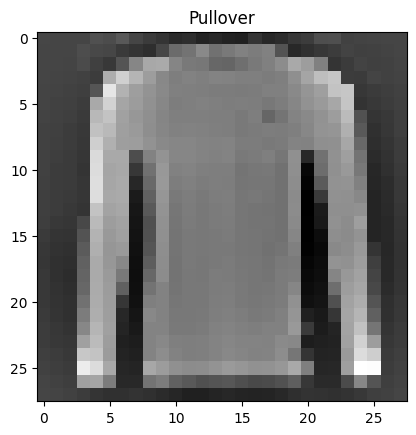

In [15]:
plt.imshow(images[y_train[y_train["label"]==2].index[4], :, :], cmap="grey")
plt.title("Pullover")
plt.show()

In [16]:
class_names = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

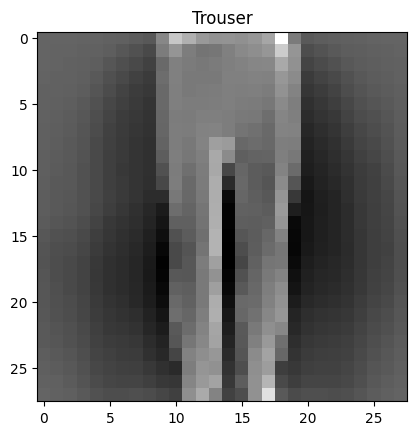

In [17]:
plt.imshow(images[y_train[y_train["label"]==1].index[2], :, :], cmap="grey")
plt.title("Trouser")
plt.show()

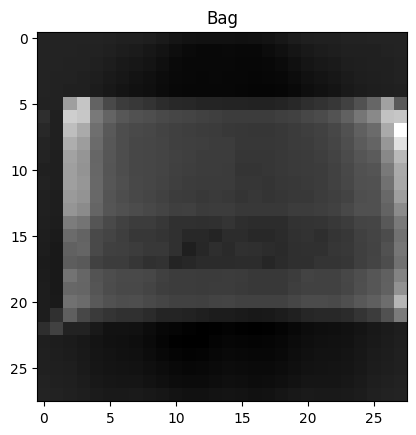

In [18]:
plt.imshow(images[y_train[y_train["label"]==8].index[4], :, :], cmap="grey")
plt.title("Bag")
plt.show()

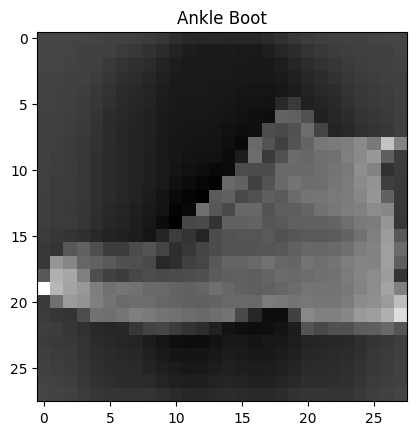

In [19]:
plt.imshow(images[y_train[y_train["label"]==9].index[2], :, :], cmap="grey")
plt.title("Ankle Boot")
plt.show()

After having visualized a few images of the fashion MNIST training data, it is now possible to proceed to data augmentation, preprocessing, and training.

## Data Augmentation

Common techniques for augmenting images are the following:
- tbd

## Building the Model, Creating the Training Loop, and Hyperparameter Tuning

Builds a class-based model and its training loop, and contains the results of hyperparameter tuning on the validation set.

In [20]:
# Model class
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 16)
    self.dropout = nn.Dropout(p=0.2)
    self.batchnorm = nn.BatchNorm1d(num_features=784, momentum=0.1)
    self.fc2 = nn.Linear(16, 8)
    self.fc3 = nn.Linear(8, 10)

  def forward(self, x):
    x = self.batchnorm(x)
    x = self.dropout(x)
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    x = self.fc3(x) # CrossEntropy loss already applies softmax

    return x

In [21]:
import torch.optim as optim
# Training loop
epochs = 7
model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001, betas=(0.9, 0.999))

for epoch in range(epochs):
  epoch_loss = 0
  val_epoch_loss = 0
  n_correct = 0
  n_val_correct = 0
  for data in train_dataloader:
    # Set gradients to zero
    optimizer.zero_grad()

    # Gets batches
    feature, target = data

    # Predictions
    preds = model(feature)

    # Calculate loss for batch
    loss = criterion(preds, target.squeeze())

    # Calculating accuracy
    preds_labels = torch.argmax(preds, dim=1).reshape(target.shape[0], 1)
    values = (preds_labels == target).float()
    n_correct += torch.sum(values)

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    epoch_loss += loss

  for val_data in val_dataloader:
    with torch.no_grad():
      val_feature, val_target = val_data

      val_preds = model(val_feature)

      val_loss = criterion(val_preds, val_target.squeeze())

      val_preds_labels = torch.argmax(val_preds, dim=1).reshape(val_target.shape[0], 1)

      val_values = (val_preds_labels == val_target).float()

      n_val_correct += torch.sum(val_values)

      val_epoch_loss += val_loss

  model.train()

  n_total = 7500
  n_val_total = 2500
  print("The loss for epoch {0} is {1}.".format(epoch+1, epoch_loss.item() / len(train_dataloader)))
  print("The accuracy for epoch {0} is {1:.2f}".format(epoch+1, 100*(n_correct/n_total)))
  print("The validation loss for epoch {0} is {1}.".format(epoch+1, val_epoch_loss.item() / len(val_dataloader)))
  print("The validation accuracy for epoch {0} is {1:.2f}".format(epoch+1, 100*(n_val_correct/n_val_total)))
  print("-------------------------------------------------------------")
  print("\n")

  # Calculate validation loss + accuracy
  model.eval()



The loss for epoch 1 is 1.2401969747340424.
The accuracy for epoch 1 is 57.12
The validation loss for epoch 1 is 0.7774810791015625.
The validation accuracy for epoch 1 is 72.16
-------------------------------------------------------------


The loss for epoch 2 is 0.6547523011552526.
The accuracy for epoch 2 is 78.59
The validation loss for epoch 2 is 0.5755842184718651.
The validation accuracy for epoch 2 is 78.36
-------------------------------------------------------------


The loss for epoch 3 is 0.5313457083194814.
The accuracy for epoch 3 is 82.24
The validation loss for epoch 3 is 0.5110248613961136.
The validation accuracy for epoch 3 is 80.92
-------------------------------------------------------------


The loss for epoch 4 is 0.46517928103183176.
The accuracy for epoch 4 is 83.83
The validation loss for epoch 4 is 0.48709304423271854.
The validation accuracy for epoch 4 is 82.28
-------------------------------------------------------------


The loss for epoch 5 is 0.4308

For a feedforward neural network with an input layer, 2 hidden layers with 64 and 32 neurons respectively, and an output layer, a training accuracy of 97-98% was reached after 20 epochs, while the validation accuracy remains between 84-85%. This huge gap between the training and validation accuracy indicates that the model is overfitting the training data.

To remedy this, the following strategies will be attempted:
- Batch Normalization
- Dropout
- Weight Decay
- Momentum

Experimenting with these values did not reduce the validation loss by much, and so the number of layers, neurons per hidden layer, and epochs had to be reduced. The final architecture looked as follows:
- **Input layer**: 784 units (flattened 28 x 28)
- **Hidden layer**: Linear(784 -> 16), followed by BatchNorm1d (momentum = 0.1), Dropout (p = 0.2) and ReLU activation.
- **Hidden layer**: Linear(16 -> 8) with ReLU activation.
- **Output layer**: (8 -> 10) with softmax application applied in CrossEntropyLoss function.

Training lasted for 7 epochs. The validation accuracy was around 83-84%%, and so decreased marginally, while the training accuracy decreased to around 87-88%, which is huge. The model no longer overfits or does so only slightly based on the gap between the training and validation accuracies.

## Test Set Evaluation

In [22]:
model.eval()
total_loss = 0
n_correct = 0
for data in test_dataloader:
  test_feature, test_target = data
  test_preds = model(test_feature)
  test_loss = criterion(test_preds, test_target.squeeze())
  total_loss += test_loss

  test_preds_labels = torch.argmax(test_preds, dim=1)
  n_correct += torch.sum((test_preds_labels == test_target).float())

test_accuracy = n_correct / len(test_dataset)
test_loss = total_loss / len(test_dataloader)

print("The test accuracy is {0:.4f}".format(test_accuracy*100))
print("The test loss is {0}".format(test_loss))

The test accuracy is 83.3267
The test loss is 0.4762767553329468


The test accuracy generally ranges from 82.5-84%, which is standard for a feedforward neural network.

## Other Metrics

## Analysis of Model Predictions

## Testing of Implementations

In [38]:
model_implemented = NeuralNetwork()
model_implemented.fit(X_train_scale, y_train)

(32, 1)
(32, 64)
(1, 64)
[[-0.50438125 -0.13060743 -0.36484205 -0.30572248 -0.51823281 -0.57799068
  -1.00344382 -0.35844332 -0.54136035 -0.43050752 -0.35669736 -0.55895118
  -0.75853532 -0.82040194 -0.41944964 -0.23191517 -0.42649739 -0.42100365
  -0.6853129  -0.72094668 -0.56195447 -0.45745296 -0.4839643  -0.29247517
  -0.43713623 -0.34753829 -0.30015592 -0.22126002 -0.594506   -0.73914707
  -0.39339342 -0.58103502 -0.42171683 -1.27349916 -0.98406831 -0.29695161
  -0.52140121 -0.57072483 -0.19192829 -0.39862678 -0.90536111 -0.67731365
  -0.25197653 -0.51649619 -1.11528628 -0.28310993 -0.65056191 -1.10726807
  -0.50154203 -0.26932114 -0.59992131 -0.51044975 -0.47319354 -0.54578427
  -0.15594079 -0.24921873 -0.36675139 -0.3341841  -0.55899067 -0.24427212
  -0.43284729 -0.88709447 -0.24199411 -0.48642728]]
(1, 64)


ValueError: operands could not be broadcast together with shapes (64,784) (1,64) 